# Dynamic topic modelling with BERTopic
### Coded by Sandrin Raphael Hunkeler (18-253-815)
### Adapted from authors of the Script (C) Elisa Michelet, and Germans Savcisens (C).
#### Url containing script: https://github.com/arobaselisa/industrial-west, https://github.com/carlomarxdk/topic_modelling

## 1. Install Dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tomotopy as tp
import time
import nltk
import wordcloud as wordcloud
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
!pip3 install kaleido==0.1.0post1
!pip3 install unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Data

In [5]:
DATA = pd.read_csv(
    #"../rawData/sampler_10ktexts_perdecade.headed.ALL2.tsv",
    "../rawData/sampler_50ktexts_perdecade.headed.ALL.tsv",
    sep='\t',
    index_col=1
)
DATA.tail()

C:\Users\Siga\AppData\Local\Temp\ipykernel_14032\4139990483.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  DATA = pd.read_csv(


,file,text
line,,
49996,200X.POS.rand,I_PP beg_VBP to_TO move_VB ._SENT
49997,200X.POS.rand,<p> Ms_NN Blears_NP :_: I_PP certainly_RB shal...
49998,200X.POS.rand,<lb/> We_PP want_VBP to_TO make_VB improvement...
49999,200X.POS.rand,<lb/> I_PP turn_VBP now_RB to_TO the_DT propos...
50000,200X.POS.rand,<lb/> I_PP seek_VBP to_TO persuade_VB the_DT C...


C:\Users\Siga\AppData\Local\Temp\ipykernel_14032\4139990483.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  DATA = pd.read_csv(


,file,text
line,,
49996,200X.POS.rand,I_PP beg_VBP to_TO move_VB ._SENT
49997,200X.POS.rand,<p> Ms_NN Blears_NP :_: I_PP certainly_RB shal...
49998,200X.POS.rand,<lb/> We_PP want_VBP to_TO make_VB improvement...
49999,200X.POS.rand,<lb/> I_PP turn_VBP now_RB to_TO the_DT propos...
50000,200X.POS.rand,<lb/> I_PP seek_VBP to_TO persuade_VB the_DT C...


## 3. Preprocessing
### 3.1 defining KEYWORDS and ROYALS name for selecting documents
### 3.2 extend STOP_WORDS by highly frequent words found in general sentences

In [7]:
KEYWORDS = [
    "king",
    "queen",
    "royalty",
    "majesty",
    "crown",
    "prince",
    "princess",
    "regent",
    "monarch",
    "highness"
]

ROYALS = [
    "Queen Victoria",
    "Queen Alexandra",
    "Queen Mary",
    "Queen Elizabeth",
    "King George",
    "King William",
    "King Edward",
    "King Edward",
    "Prince Albert",
    "Prince Edward",
    "Prince George",
    "Princess Victoria",
    "Princess Louise",
    "Princess Alexandra",
    "Princess Mary",
    "Princess Margaret"
]

STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
STOP_WORDS.update({
    'hon',
    'mr',
    'gentleman',
    'gent',
    'gen',
    'right',
    'house',
    'opinion',
    'sir',
    'say',
    'friend',
    'member',
    'think',
    'go',
    'motion'
    'noble',
    'lord',
    'case',
    'year',
    'speak',
    'speech'
})

SPACY_LANGUAGE = "en_core_web_sm"
COUNTRY = "US"
LANG = "en"
data = DATA

### 3.3 remove functional words
### 3.4 lemmatize words by POS tags

In [8]:
def corpusRefactoring(data):
    data.drop(data[~data['file'].astype(str).str.endswith('POS.rand')].index, inplace=True)
    data['file'] = data['file'].map(lambda x: x.rstrip('X.POS.rand'))
    data['file'] = data['file'].astype(str) + '0'
    data['file'] = pd.to_datetime(data['file'], format='%Y')
    data['file'] = pd.DatetimeIndex(data['file'])
    data.rename(columns={"file":"timePeriod", "text":"content"}, inplace=True)
    data.dropna(inplace = True)
    data.reset_index(drop=True, inplace=True)
    return data

def create_corpus(data):
    raw_articles = data["content"].to_list()
    corpus = tp.utils.Corpus()
    for doc in raw_articles:
        if doc:
            corpus.add_doc(doc.split())
    return _,  corpus

wn = WordNetLemmatizer()

def lemmatize(word):
    if '_' not in word: return ""
    token, posStart = word.split('_')[0].lower(), word.split('_')[1].upper()
    if posStart.startswith('N'):
        return wn.lemmatize(token, wordnet.NOUN)
    elif posStart.startswith('V'):
        return wn.lemmatize(token, wordnet.VERB)
    elif posStart.startswith('R'):
        return wn.lemmatize(token, wordnet.ADV)
    elif posStart.startswith('J'):
        return wn.lemmatize(token, wordnet.ADJ)
    return ""

def isRoyalTopic(text):
    if len(text.split()) < 4: return False
    overlapRoyals = any(word in ROYALS for word in text.split())
    overlapKeyWords = any(word in KEYWORDS for word in text.split())
    return overlapRoyals or overlapKeyWords

def preprocess_text(text):
    tokens = simple_preprocess(text)
    clean = [lemmatize(word) for word in tokens if lemmatize(word)!=""]
    words = [word for word in clean if word.isalpha()]
    lemmas = [word for word in words if word not in STOP_WORDS]
    return " ".join(lemmas)

In [9]:
corpusRefactoring(data)
data.loc[:, 'content'] = data['content'].apply(preprocess_text).astype(str)
data['royal'] = data['content'].apply(isRoyalTopic)
data.drop(data[data.royal == False].index, inplace=True)
data.dropna(inplace = True)
data.tail()

,timePeriod,content,royal
800741,2000-01-01,viscount craigavon ask majesty government impo...,True
800786,2000-01-01,utterly wrong change name ruc remove royal cro...,True
801631,2000-01-01,chris bryant rhondda much hate agree liberal d...,True
801911,2000-01-01,also confirm majesty government make clear pri...,True
802259,2000-01-01,king bridgwater minister recall debate invasio...,True


In [14]:
#data = data.groupby("timePeriod").sample(frac=0.01, random_state=42)
processedData = data
processedData.head()

,timePeriod,content,royal
45,1800-01-01,mention address removal present majesty though...,True
57,1800-01-01,general respect convention differ point reason...,True
61,1800-01-01,commencement gracious beneficent reign present...,True
81,1800-01-01,canning command majesty present bar copy paten...,True
110,1800-01-01,wa measure institute necessity crown power gra...,True


### 3.5 oversee the document frequencies

<Axes: xlabel='timePeriod'>

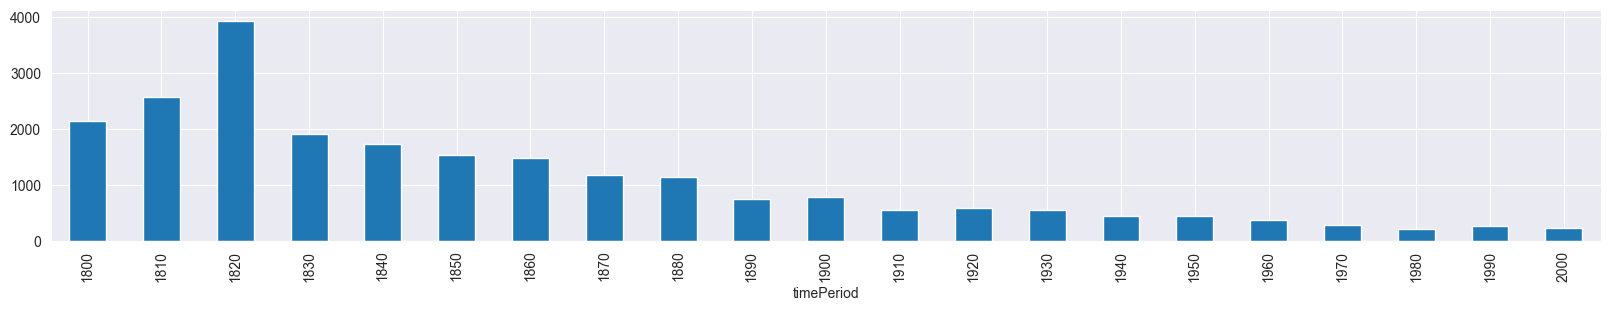

In [11]:
data.groupby(data["timePeriod"].dt.year).size().plot(kind="bar", figsize=(20, 3))

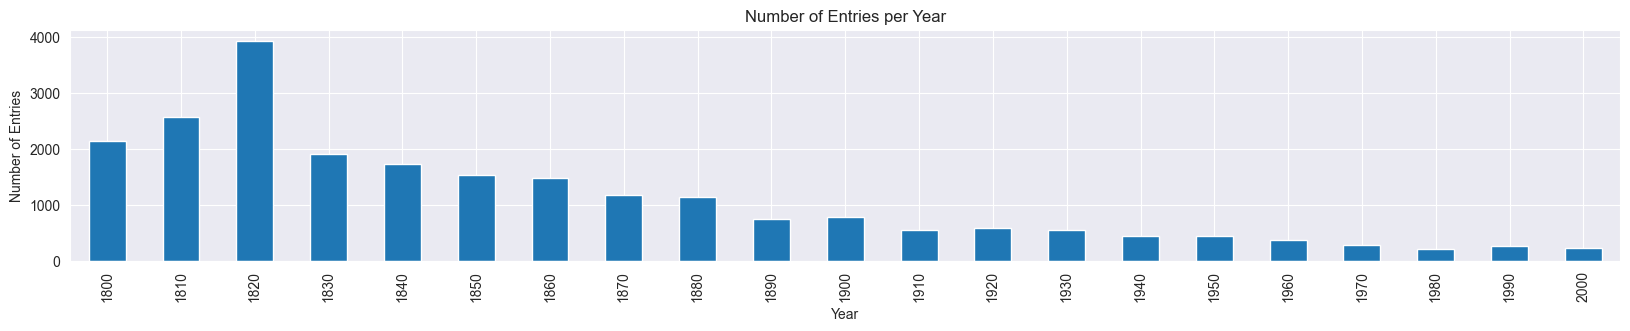

In [15]:
import matplotlib.pyplot as plt
data.groupby(data["timePeriod"].dt.year).size().plot(kind="bar", figsize=(20, 3))
plt.title("Number of Entries per Year")
plt.xlabel("Year")
plt.ylabel("Number of Entries")
plt.savefig("../diagramOutput/frequencyDistributionRawDocuments.png", dpi=600, format='png')

## 4. Pachinko Allocation Modell
### 4.1 Create Corpus

In [16]:
_, corpus = create_corpus(data)

### 4.2 Analyze optimal number of topics

In [ ]:
###### You should change only this
k1_max = 3 ###(min 1) if k1_max - 1 == best k1
k2_max = 25
### k2 should always be higher than k1 (min 1)
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF, min_df=10, rm_top=10, k1=k1, k2=k2, corpus=corpus, seed=0)
        model.train(500, workers=1)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score() #try with 'u_mass' instead of 'c_v' 
        params.append((k1,k2))
        scores.append(score)
        print(f"Runtime: {int(time.time() - start)} seconds", f"|| Number of Searches: {num_iter}, {max_iter}")

Runtime: 38 seconds || Number of Searches: 1, 47
Runtime: 79 seconds || Number of Searches: 2, 47
Runtime: 130 seconds || Number of Searches: 3, 47
Runtime: 182 seconds || Number of Searches: 4, 47
Runtime: 235 seconds || Number of Searches: 5, 47
Runtime: 290 seconds || Number of Searches: 6, 47
Runtime: 350 seconds || Number of Searches: 7, 47
Runtime: 412 seconds || Number of Searches: 8, 47
Runtime: 478 seconds || Number of Searches: 9, 47
Runtime: 556 seconds || Number of Searches: 10, 47


In [ ]:
best_params = np.argmax(scores)
print("(BEST MODEL) k1=%s k2=%s coherence=%.2f"  %(params[best_params][0], params[best_params][1],  scores[best_params]))

data = pd.DataFrame(data={'k1':list(zip(*params))[0], 'k2':list(zip(*params))[1], 'score':scores})
data = data.pivot(index='k1', columns='k2', values='score')
sns.heatmap(data)
plt.show()

### 4.3 Train Model

In [ ]:
best_k1 = params[best_params][0]
best_k2 = params[best_params][1]
model = tp.PAModel(tw=tp.TermWeight.IDF, min_cf=5, k1=best_k1, k2=best_k2, corpus=corpus, seed=0)

model.burn_in=100
model.train(1000, workers=1)

### 4.4 Print extracted topics

In [ ]:
top_n = 10
for k in range(best_k2):
    print("TOPIC", k)
    print("Words:")
    print([item[0] for item in model.get_topic_words(k, top_n=top_n)])
    print("==========================")

### 4.5 Visualize number of documents per topic

In [ ]:
infered, ll = model.infer(corpus)
topic_data = np.zeros((len(infered),model.k2) )
for i, doc in enumerate(infered):
    temp = doc.get_sub_topics()
    for item in temp:
        topic_data[i, item[0]] = item[1]
topic_data = pd.DataFrame(topic_data)
topic_data["TOPIC"] = topic_data.apply(lambda x: np.argmax(x), axis=1)
topic_labels = topic_data["TOPIC"].values
plt.bar(["Topic %s" %i for i in range(model.k2)],topic_data["TOPIC"].value_counts(), width=0.3)
plt.title("Number of documents per topic")
plt.ylabel("# of documents")
plt.show()

## 5. Sentiments
### 5.1 set up sentiment analyzer

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    sia = SentimentIntensityAnalyzer()
except:
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()
def return_sentiment(doc):
    """
    Helper function to estimate the sentiment scores
    """
    return sia.polarity_scores(" ".join([model.vocabs[w] for w in doc.words]))
print("Analyzer is ready")

### 5.2 Process Sentiments

In [ ]:
sentiment_data = np.zeros((len(infered), 4))
for i, doc in enumerate(infered):
    sentiment_data[i] = list(return_sentiment(doc).values())

keys = list(return_sentiment(doc).keys())
for i, k in enumerate(keys):
    topic_data[k] = sentiment_data[:,i]
print("Sentiments Calculated")

### 5.3 Visualize Sentiments

In [ ]:
from scipy.stats import median_abs_deviation
import wordcloud

fig, ax = plt.subplots( model.k2 + 1,2, figsize=(20, 5 * (model.k2 + 1)))
bins = np.linspace(-1,1, 20)

scores = topic_data["compound"]
ax[0,0].hist(scores, bins=bins)
ax[0,0].set_title("Sentiment Distribution (Full), median: %.2f, mad: %.2f " %(np.median(scores),
                                                                                  median_abs_deviation(scores)))
ax[0,0].set_ylabel("# of documents")
ax[0,0].set_xlabel("Sentiment Score")
ax[0,0].axvline(scores.median(), color='k', linestyle='dashed', linewidth=2)
ax[0,0].set_xlim([-1,1])

ax[0,1].imshow(np.zeros((10,10)))
ax[0,1].set_title("Should be empty")
ax[0,1].axis("off")

wc = wordcloud.WordCloud(height=300, background_color="white")
for i in range(model.k2):
    scores = topic_data[topic_data["TOPIC"] == i]["compound"]
    ax[i + 1,0].hist(scores, bins=bins)
    ax[i + 1,0].set_ylabel("# of documents")
    ax[i + 1,0].set_xlim([-1,1])
    ax[i + 1,0].set_xlabel("Sentiment Score")
    ax[i + 1,0].set_title("Sentiment Distribution (TOPIC %s), median: %.2f, mad: %.2f " %(i, np.median(scores),
                                                                                  median_abs_deviation(scores)))
    ax[i + 1,0].axvline(scores.median(), color='k', linestyle='dashed', linewidth=2)

    vocab = dict()
    for item in model.get_topic_words(i, top_n=200):
        vocab[item[0]] = item[1]
    ax[i + 1,1].imshow(wc.generate_from_frequencies(vocab), interpolation="bilinear")
    ax[i + 1,1].set_title("WordCloud for Topic %s" %i)
    ax[i + 1,1].axis("off")
plt.tight_layout()
plt.savefig("../diagramOutput/sentimentWordCloud.png", dpi=600, format='png')
plt.show()